# Notebook using SectorPhi from SasView

Please refer to `https://github.com/SasView/sasdata` for installation instructions.
In addition, for this notebook, you'll have to install `matplotlib` and `numpy` using:

In [29]:
!python -m pip install matplotlib numpy

## Load libraries

In [30]:
from sasdata.dataloader.loader import Loader
import matplotlib.pyplot as plt
import numpy as np

from sasdata.dataloader.data_info import plottable_2D
from sasdata.data_util.manipulations import SectorPhi
import os

from matplotlib.colors import LogNorm
import matplotlib as mpl

plt.rcParams.update({'font.size': 16})

## Sign convention
The figure below shows the convention of origin and orientation for the azimuthal angle $\phi$ used in SasView.

**Note:** Method to plot the following figure inspired from https://stackoverflow.com/questions/37512502/how-to-make-arrow-that-loops-in-matplotlib

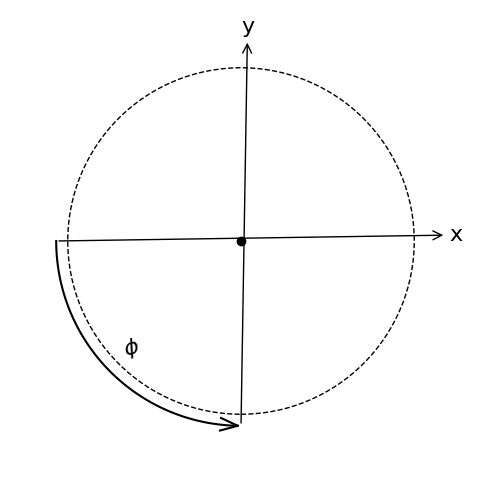

In [4]:
radius = 1.6

fig, ax = plt.subplots(figsize=(6,6))

# Draw point at origin
ax.plot(0, 0, color = 'black', marker = 'o')

# Draw circle
a_circle_max = plt.Circle((0, 0), 
                          radius-0.1, 
                          fill=False, 
                          edgecolor="black", 
                          linestyle="--")
ax.add_artist(a_circle_max)

# Draw body of arrow
x = [-radius * np.cos(np.deg2rad(ang)) for ang in np.arange(90)]
y = [-radius * np.sin(np.deg2rad(ang)) for ang in np.arange(90)]
ax.plot(x, y, 'black')

# Draw arrow head
xlast = x[-1]
ylast = y[-1]

x = [xlast + 0.1 * radius * np.cos(np.deg2rad(195)), 
     xlast, 
     xlast + 0.1 * radius * np.cos(np.deg2rad(155))]
y = [ylast + 0.1 * radius * np.sin(np.deg2rad(195)), 
     ylast, 
     ylast + 0.1 * radius * np.sin(np.deg2rad(155))]

ax.plot(x, y, 'black')

# Add labels
ax.annotate("y", 
            xy=(0, -radius),
            xytext=(0, 1.8),
            arrowprops=dict(arrowstyle="<-"))
ax.annotate("x", 
            xy=(-radius, 0), 
            xytext=(1.8, 0), 
            arrowprops=dict(arrowstyle="<-"))

ax.text(-1, -1, r"$\phi$", ha='left', rotation=15, wrap=True)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Remove axes and frame 
ax.set_aspect('equal')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.axis('off');

## Load data

The datafile is part of the SasView test suite.

In [5]:
data_run = Loader().load("./notebook_files/P123_D2O_10_percent.dat")

qx_data = data_run[0].qx_data
qy_data = data_run[0].qy_data
data = data_run[0].data
q_data = np.sqrt(qx_data**2 + qy_data**2)
name = os.path.splitext(os.path.basename(data_run[0].filename))[0]

## Define sector

In [6]:
# number of sectors for phi between 0 and 2Pi
nbins_phi = 6

# minimum and maximum of ||q|| range
r_min = 0.01
r_max = 0.7 * np.sqrt(qx_data.max()**2 + qy_data.max()**2)

sect = SectorPhi(r_min=r_min, 
                 r_max=r_max,
                 phi_min=0,
                 phi_max=2 * np.pi,
                 nbins=nbins_phi)

print(f"r_max={sect.r_max}, r_min={sect.r_min}, phi_max={sect.phi_max}, phi_min={sect.phi_min}.")

r_max=0.09800499987245548, r_min=0.01, phi_max=6.283185307179586, phi_min=0.


## Visualise azimuthal sectors

In [7]:
qx_data_1d = data_run[0].x_bins
qy_data_1d = data_run[0].y_bins

nb_points_x = len(qx_data_1d)
nb_points_y = len(qy_data_1d)
lines_sectors = np.zeros((sect.nbins, nb_points_x))

for i in range(sect.nbins):
    lines_sectors[i,:] = np.tan((sect.phi_max - sect.phi_min) / sect.nbins * i) * qx_data_1d

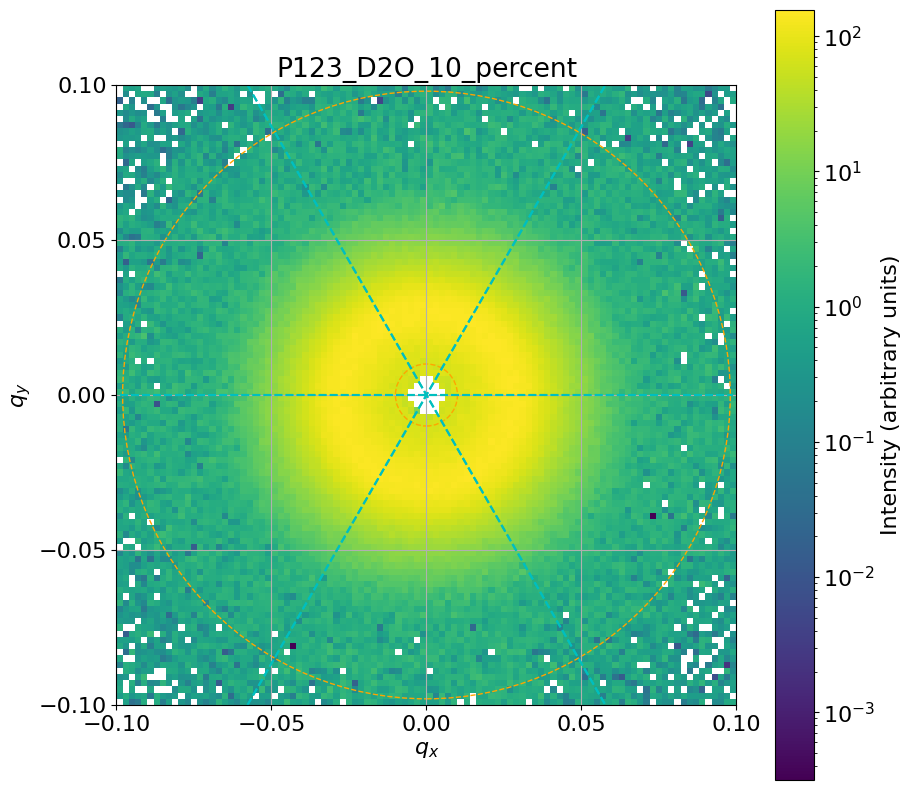

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
c = plt.pcolormesh(
    qx_data_1d,
    qy_data_1d,
    data.reshape(nb_points_x, nb_points_y), 
    norm=LogNorm())

# plot sectors' limits
for i in range(sect.nbins):
    ax.plot(qx_data_1d, lines_sectors[i, :], 'c--')
    
# plot rmin, rmax
a_circle_min = plt.Circle(
    (0, 0), 
    r_min, 
    fill=False, 
    edgecolor="orange", 
    linestyle="--")

ax.add_artist(a_circle_min)

a_circle_max = plt.Circle(
    (0, 0), 
    r_max, 
    fill=False, 
    edgecolor="orange", 
    linestyle="--")

ax.add_artist(a_circle_max)

ax.grid()
ax.set_aspect('equal', 'box')
ax.set_xlim((np.min(qx_data_1d), np.max(qx_data_1d)))
ax.set_ylim((np.min(qy_data_1d), np.max(qy_data_1d)))
ax.set_xticks(np.linspace(-0.1, 0.1, 5))
ax.set_yticks(np.linspace(-0.1, 0.1, 5))
ax.set(title=name, xlabel=r'$q_x$', ylabel=r'$q_y$')
cbar = plt.colorbar(c, label='Intensity (arbitrary units)');

## Calculate average

In [9]:
# make the data plottable in order to be able to use SectorPhi
data_plottable = plottable_2D(
    data=data,
    err_data=np.zeros(data.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=q_data)

sector = sect(data_plottable)

## Plot result

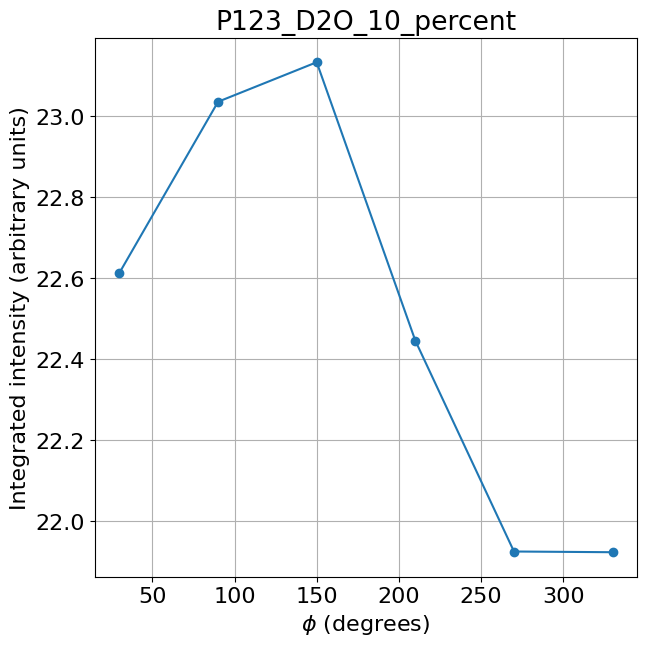

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(np.rad2deg(sector.x), sector.y, 'o-')
ax.set(title=name,
       xlabel=r'$\phi$ (degrees)',
       ylabel='Integrated intensity (arbitrary units)')
ax.grid();

## Tests of `sectorPhi` with simple 2D cases

For the following tests, we only consider the full $\phi$-range = 0, 2 $\pi$ divided into 4 sectors.  
We want to check the correctness of the average calculated in all $\phi$ sectors using different simple 2D cases.

### Settings for the $q$-vectors

In [11]:
nbins = 150

qx_data_1d = np.linspace(-0.149, 0.149, nbins)

qy_data_1d = qx_data_1d

qx_data = []
qy_data = []

for i in range(nbins):
    qx_data.append(qx_data_1d)
    qy_data.append(nbins*[qx_data_1d[i]])

qx_data = np.asarray(qx_data)
qy_data = np.asarray(qy_data)
q_data = np.sqrt(qx_data**2 + qy_data**2)

nb_points_x = len(qx_data_1d)
nb_points_y = len(qy_data_1d)

qx_data = qx_data.flatten()
qy_data = qy_data.flatten()

### Settings for `SectorPhi`

In [12]:
nbins_phi = 4
r_min = 0.0
# large r_max to consider all points of the input matrix
r_max = 2 * np.sqrt(qx_data.max()**2 + qy_data.max()**2)

sect = SectorPhi(r_min=r_min, 
                 r_max=r_max,
                 phi_min=0,
                 phi_max=2 * np.pi,
                 nbins=nbins_phi)

### Definitions of the borders of the azimuthal sectors
These lines are used to plot over the 2D image to check the settings.

In [13]:
lines_sectors = np.zeros((sect.nbins, nb_points_x))

for i in range(sect.nbins):
    lines_sectors[i,:] = np.tan((sect.phi_max - sect.phi_min) / sect.nbins * i) * qx_data_1d

In [14]:
def plot_settings(data, title_plot):
    """
    Plot 2D image with layout of azimuthal sectors and radial q-area to be used for averaging
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal', 'box')
    c = plt.pcolormesh(
        qx_data_1d,
        qy_data_1d,
        data.reshape(nb_points_x, nb_points_y), 
        norm=LogNorm())
    
    # plot sectors' limits
    for i in range(sect.nbins):
        ax.plot(qx_data_1d, lines_sectors[i, :], 'c--')
    
    # plot rmin, rmax
    a_circle_min = plt.Circle(
        (0, 0),
        r_min,
        fill=False,
        edgecolor="orange",
        linestyle="--")

    ax.add_artist(a_circle_min)

    a_circle_max = plt.Circle(
        (0, 0), 
        r_max, 
        fill=False, 
        edgecolor="orange", 
        linestyle="--")

    ax.add_artist(a_circle_max)

    ax.grid()
    ax.set_xlim((np.min(qx_data_1d), np.max(qx_data_1d)))
    ax.set_ylim((np.min(qy_data_1d), np.max(qy_data_1d)))
    ax.set(title=title_plot,
           xlabel=r'$q_x$',
           ylabel=r'$q_y$')
    cbar = plt.colorbar(c);  


def plot_result(sector_phi, title_plot):
    """
    Plot azimuthal average as function of phi in degrees
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(np.rad2deg(sector_phi.x), sector_phi.y, 'o-')
    ax.grid()
    ax.set(title=title_plot, 
           xlabel=r'$\phi$ (degrees)', 
           ylabel='Integrated intensity (arbitrary units)')

## Case 1: Matrix of 1s

The square matrix is filled with 1.

In [15]:
data_ones = np.ones((nbins, nbins)).flatten()

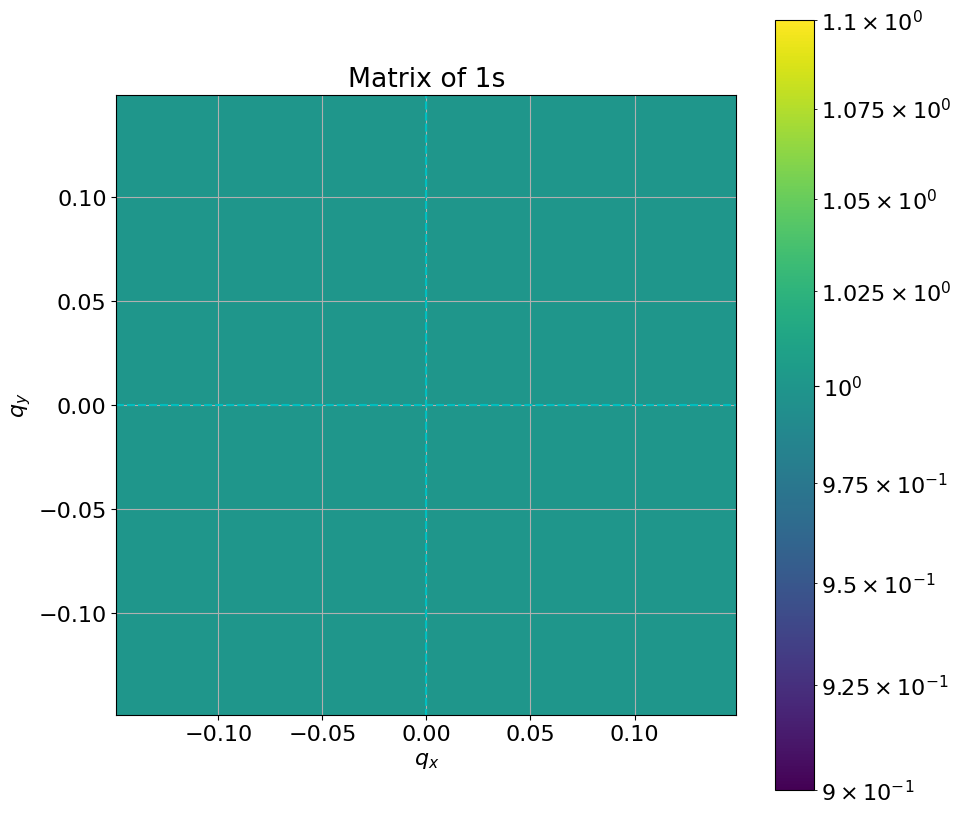

In [16]:
plot_settings(data_ones, 'Matrix of 1s')

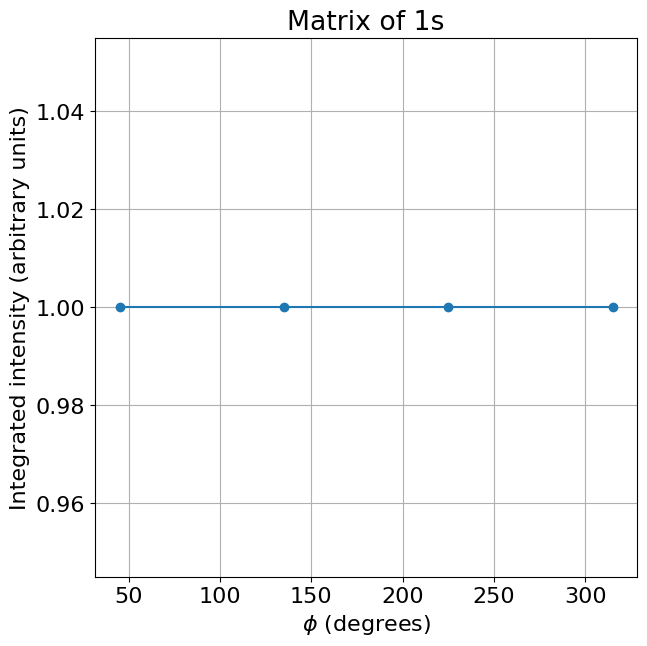

In [17]:
# make the data plottable in order to be able to use SectorPhi
data_plottable_ones= plottable_2D(
    data=data_ones,
    err_data=np.zeros(data_ones.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=np.sqrt(qx_data**2 + qy_data**2))

sector_ones = sect(data_plottable_ones)

plot_result(sector_ones, 'Matrix of 1s')

In [18]:
np.testing.assert_array_equal(
    sector_ones.y,
    np.ones(4), 
    err_msg="""The result from SectorPhi does not correspond to the theoretical value."""
)

## Case 2: Disk of 1s centered at 0,0

In [19]:
data_circle = np.zeros((nbins, nbins))

# counts per sectors 

count_mm = 0  # q_x<0, q_y<0
count_mp = 0  # q_x<0, q_y>0
count_pm = 0  # q_x>0, q_y<0
count_pp = 0  # q_x>0, q_y>0

for i in range(nbins):
    for j in range(nbins):   
        if np.sqrt((i-nbins//2)**2 + (j-nbins//2)**2) < 20:
            data_circle[i, j] = 1
            # count ones in each sector
            if qx_data_1d[i]>0:
                if qy_data_1d[j]>0:
                    count_pp += 1
                else:
                    count_pm += 1
            else:
                if qy_data_1d[j]>0:
                    count_mp += 1
                else:
                    count_mm += 1  
            
data_circle = data_circle.flatten()

In [20]:
assert np.count_nonzero(data_circle==1) == count_mm + count_pp + count_mp + count_pm, \
"""Some of the 1-values have been missed."""

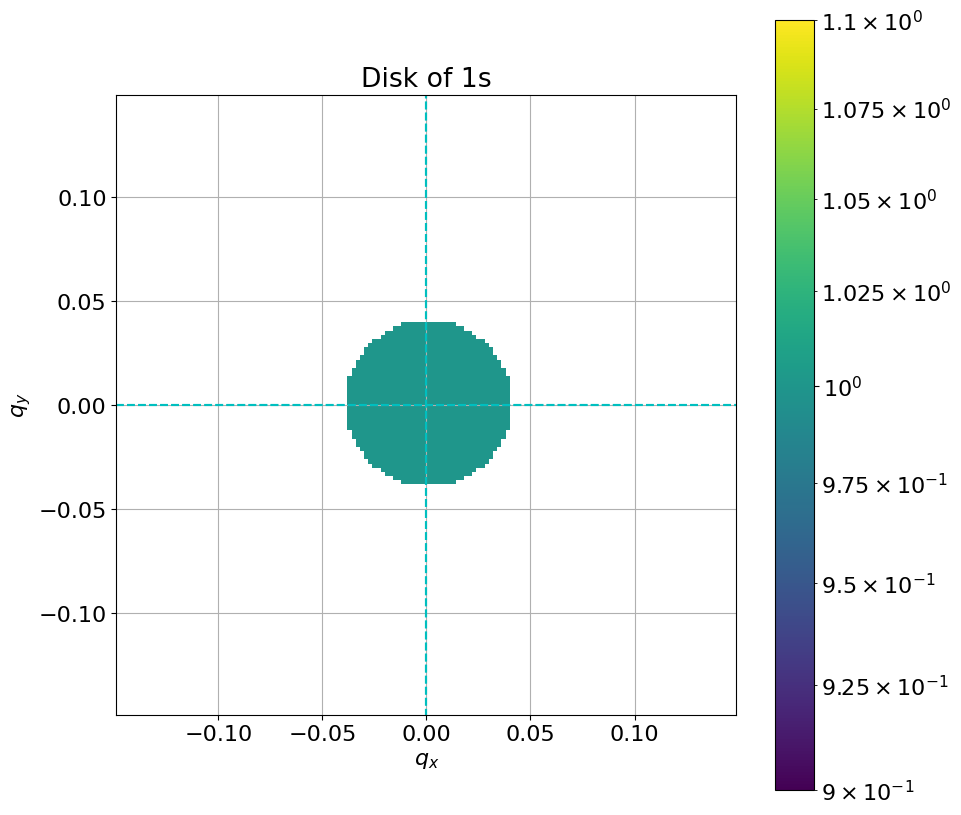

In [21]:
plot_settings(data_circle, 'Disk of 1s')

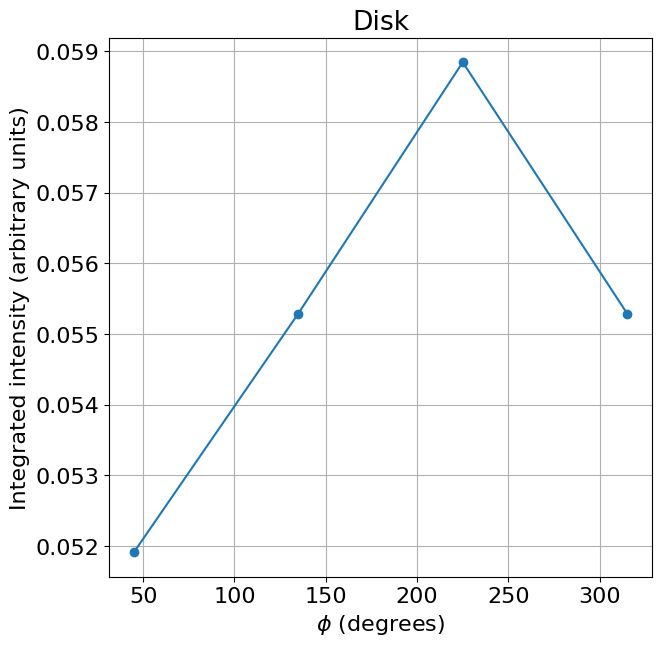

In [22]:
# make the data plottable in order to be able to use SectorPhi
data_plottable_c = plottable_2D(
    data=data_circle,
    err_data=np.zeros(data_circle.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=np.sqrt(qx_data**2 + qy_data**2))

sector_circle = sect(data_plottable_c)

plot_result(sector_circle, 'Disk')

In [23]:
# check that the azimuthal average corresponds to the number of ones per sector divided 
# by the size of the sector.
nbins_per_sect = (nbins**2/nbins_phi)
assert all(sector_circle.y == [
    count_mm/nbins_per_sect, 
    count_mp/nbins_per_sect, 
    count_pp/nbins_per_sect,
    count_pm/nbins_per_sect]), \
""" the result from SectorPhi does not correspond to the number of ones per sector divided 
by the number of bins per sector"""

## Case 3: circle centered at 0, 0 with zeros at the sectors' edges

In [24]:
data_circle0 = np.zeros((nbins, nbins))

# counts per sectors 

count_mm = 0  # q_x<0, q_y<0
count_mp = 0  # q_x<0, q_y>0
count_pm = 0  # q_x>0, q_y<0
count_pp = 0  # q_x>0, q_y>0

for i in range(nbins):
    for j in range(nbins):
        if np.sqrt((i - nbins//2)**2 + (j - nbins//2)**2) < 20:
            data_circle0[i, j] = 1
            
            if qx_data_1d[i]>0:
                if qy_data_1d[j]>0:
                    count_pp += 1
                else:
                    count_pm += 1      
            else: 
                if qy_data_1d[j]>0:
                    count_mp += 1
                else:
                    count_mm += 1  
            
            if i-nbins//2 == 0 or j-nbins//2 == 0:   
                data_circle0[i, j] = 0
                if qx_data_1d[i]>0:
                    if qy_data_1d[j]>0:
                        count_pp -= 1
                    else: 
                        count_pm -= 1    
                else: 
                    if qy_data_1d[j]>0:
                        count_mp -= 1
                    else:
                        count_mm -= 1  

data_circle0 = data_circle0.flatten()

In [25]:
assert np.count_nonzero(data_circle0==1) == count_mm+count_pp+count_mp+count_pm, \
"""Some of the 1-values have been missed."""

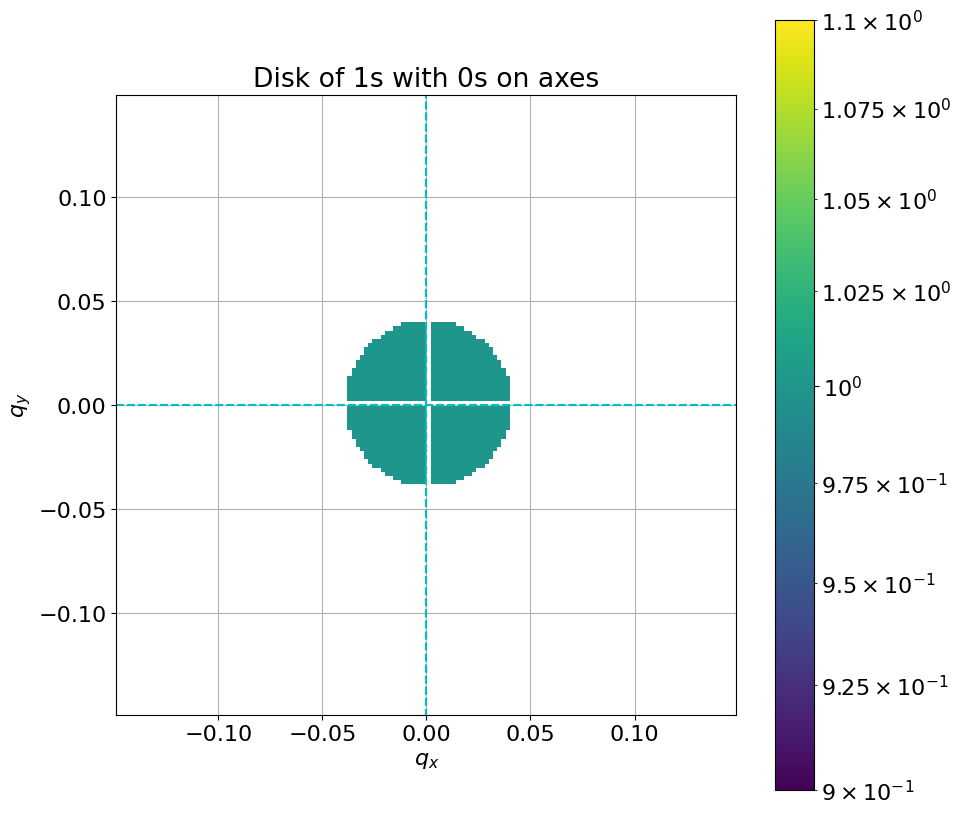

In [26]:
plot_settings(data_circle0, 'Disk of 1s with 0s on axes')

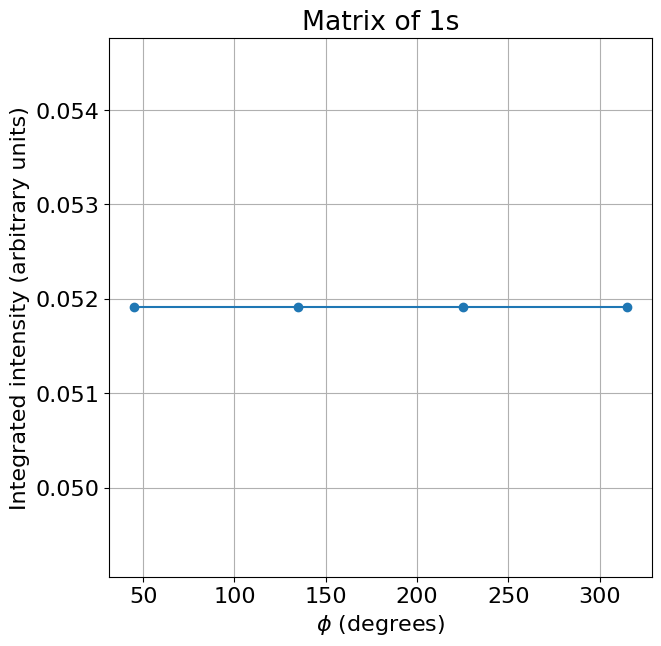

In [27]:
# make the data plottable in order to be able to use SectorPhi
data_plottable_c0 = plottable_2D(
    data=data_circle0,
    err_data=np.zeros(data_circle0.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=np.sqrt(qx_data**2+qy_data**2)
)

sector_circle0 = sect(data_plottable_c0)

plot_result(sector_circle0, 'Matrix of 1s')

In [28]:
# check that the azimuthal average corresponds to the number of ones per sector divided 
# by the size of the sector.
nbins_per_sect = (nbins**2/nbins_phi)
assert all(sector_circle0.y == [
    count_mm/nbins_per_sect, 
    count_mp/nbins_per_sect, 
    count_pp/nbins_per_sect, 
    count_pm/nbins_per_sect]),\
"""the result from SectorPhi does not correspond to the number of ones per sector divided 
by the number of bins per sector"""

## Case 4: small square of 1s

In [ ]:
data_square = np.zeros((nbins, nbins))

# counts per sectors 
count_mm = 0  # q_x<0, q_y<0
count_mp = 0  # q_x<0, q_y>0
count_pm = 0  # q_x>0, q_y<0
count_pp = 0  # q_x>0, q_y>0

for i in range(nbins):
    for j in range(nbins):
        if abs(i-nbins//2) <20 and abs(j-nbins//2) < 20:
            data_square[i, j] = 1
            # count ones in each sector
            if qx_data_1d[i]>0:
                if qy_data_1d[j]>0:
                    count_pp += 1
                else:
                    count_pm += 1
            else:
                if qy_data_1d[j]>0:
                    count_mp += 1
                else:
                    count_mm += 1
            
data_square = data_square.flatten()

In [ ]:
# check that the sum of all 4 counts corresponds to the number of ones
assert np.count_nonzero(data_square == 1) == count_mm + count_mp + count_pm + count_pp, \
"""Some of the 1-values have been missed."""

In [ ]:
plot_settings(data_square, 'Square of 1s')

In [ ]:
# make the data plottable in order to be able to use SectorPhi
data_plottable_sq = plottable_2D(
    data=data_square,
    err_data=np.zeros(data_square.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=np.sqrt(qx_data**2 + qy_data**2)
)

sector_sq = sect(data_plottable_sq)

plot_result(sector_sq, 'Square of 1s')

In [ ]:
# check that the azimuthal average corresponds to the number of ones per sector divided 
# by the size of the sector.
nbins_per_sect = (nbins**2/nbins_phi)
assert all(sector_sq.y == [
    count_mm/nbins_per_sect, 
    count_mp/nbins_per_sect, 
    count_pp/nbins_per_sect, 
    count_pm/nbins_per_sect]),\
"""the result from SectorPhi does not correspond to the number of ones per sector divided 
by the number of bins per sector"""

## Case 5: small square of 1s and 0s on the axes

In [ ]:
data_square0 = np.zeros((nbins, nbins))

# counts per sectors 
count_mm = 0  # q_x<0, q_y<0
count_mp = 0  # q_x<0, q_y>0
count_pm = 0  # q_x>0, q_y>0
count_pp = 0  # q_x>0, q_y>0

for i in range(nbins):
    for j in range(nbins):
        if 0 < abs(i-nbins//2) < 20 and 0 < abs (j-nbins//2) < 20:
            data_square0[i, j] = 1
            # count ones in each sector
            if qx_data_1d[i]>0:
                if qy_data_1d[j]>0:
                    count_pp += 1
                else:
                    count_pm += 1
            else:
                if qy_data_1d[j]>0:
                    count_mp += 1
                else:
                    count_mm += 1  

data_square0 = data_square0.flatten()

In [ ]:
assert np.count_nonzero(data_square0==1) == count_mm + count_pp + count_mp + count_pm, \
"""Some of the 1-values have been missed."""

In [ ]:
plot_settings(data_square0, 'Square of 1s with 0s on axes')

In [ ]:
# make the data plottable in order to be able to use SectorPhi
data_plottable_sq0 = plottable_2D(
    data=data_square0,
    err_data=np.zeros(data_square0.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=np.sqrt(qx_data**2 + qy_data**2)
)

sector_sq0 = sect(data_plottable_sq0)

plot_result(sector_sq0, 'Square0')

In [ ]:
# check that the azimuthal average corresponds to the number of ones per sector divided 
# by the size of the sector.
nbins_per_sect = (nbins**2/nbins_phi)
assert all(sector_sq0.y == [
    count_mm/nbins_per_sect,
    count_mp/nbins_per_sect,
    count_pp/nbins_per_sect,
    count_pm/nbins_per_sect]),\
"""the result from SectorPhi does not correspond to the number of ones per sector divided by 
the number of bins per sector"""

## Case 6: quadrant with different constant values in each sector

In [ ]:
data_quadrant = np.zeros((nbins, nbins))

# counts per sectors 
# (the index marks the area containing this value
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0

for i in range(nbins):
    for j in range(nbins):
        if i < nbins//2:
            if j < nbins//2:
                data_quadrant[i, j] = 3
                count_3 += 1
            else:
                data_quadrant[i, j] = 4
                count_4 += 1
        else:
            if j < nbins//2:
                data_quadrant[i, j] = 2
                count_2 += 1
            else:
                data_quadrant[i, j] = 1
                count_1 += 1

data_quadrant = data_quadrant.flatten()

In [ ]:
# Check the count for each sector
assert np.count_nonzero(data_quadrant == 1) == count_1
assert np.count_nonzero(data_quadrant == 2) == count_2
assert np.count_nonzero(data_quadrant == 3) == count_3
assert np.count_nonzero(data_quadrant == 4) == count_4

In [ ]:
fig, ax = plt.subplots()

cmap = mpl.colors.ListedColormap(['#2c7bb6','#e389b9', '#746ab0', '#6c5b7b'])
norm = mpl.colors.BoundaryNorm([0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)

c = plt.pcolormesh(
    qx_data_1d, 
    qy_data_1d, 
    data_quadrant.reshape(nb_points_x, nb_points_y),
    cmap=cmap,
    norm=norm)

# plot sectors' limits
for i in range(sect.nbins):
    ax.plot(qx_data_1d, lines_sectors[i, :], 'c--')
    
# plot rmin, rmax
a_circle_min = plt.Circle((0, 0), r_min, fill=False, edgecolor="orange", linestyle="--")
ax.add_artist(a_circle_min)

a_circle_max = plt.Circle((0, 0), r_max, fill=False, edgecolor="orange", linestyle="--")
ax.add_artist(a_circle_max)

ax.grid()
ax.set_xlim((np.min(qx_data_1d), np.max(qx_data_1d)))
ax.set_ylim((np.min(qy_data_1d), np.max(qy_data_1d)))
ax.set(title='Quadrant',
       xlabel=r'$q_x$',
       ylabel=r'$q_y$')
cbar = plt.colorbar(c, ticks=[1, 2, 3, 4], format='%d');

In [ ]:
# make the data plottable in order to be able to use SectorPhi
data_plottable_q = plottable_2D(
    data=data_quadrant,
    err_data=np.zeros(data_quadrant.shape),
    qx_data=qx_data,
    qy_data=qy_data, 
    q_data=np.sqrt(qx_data**2 + qy_data**2))

sector_quadrant = sect(data_plottable_q)

plot_result(sector_sq0, 'Quadrant')

In [ ]:
sector_quadrant.y